In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier #, MinCut2_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  include logger

In [15]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
with th.autograd.detect_anomaly():
    pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=8e-4,
    epochs=5_000,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    burn_in=50)

/tmp/ipykernel_3746/1931389116.py:8: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with th.autograd.detect_anomaly():


Epoch 0: Training loss 14.4861; Validation loss 15.6725, MAE: 15.9311; lr: 0.00080
	Add. Loss: Training 0.2482, Validation 0.2320
Epoch 5: Training loss 5.0546; Validation loss 15.0702, MAE: 15.3251; lr: 0.00080
	Add. Loss: Training 0.2380, Validation 0.2379
Epoch 10: Training loss 3.9739; Validation loss 15.6436, MAE: 15.8967; lr: 0.00080
	Add. Loss: Training 0.2407, Validation 0.2380
Epoch 15: Training loss 3.1987; Validation loss 15.2439, MAE: 15.5070; lr: 0.00080
	Add. Loss: Training 0.2398, Validation 0.2297
Epoch 20: Training loss 3.1916; Validation loss 14.6392, MAE: 14.8924; lr: 0.00080
	Add. Loss: Training 0.2397, Validation 0.2373
Epoch 25: Training loss 2.7141; Validation loss 14.1973, MAE: 14.4475; lr: 0.00080
	Add. Loss: Training 0.2371, Validation 0.2377
Epoch 30: Training loss 2.7279; Validation loss 14.6816, MAE: 14.9353; lr: 0.00080
	Add. Loss: Training 0.2359, Validation 0.2322
Epoch 35: Training loss 2.4199; Validation loss 14.4746, MAE: 14.7331; lr: 0.00080
	Add. Lo

/home/milan/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in SqrtBackward0. Traceback of forward call that caused the error:
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/milan/anaconda3/envs/torch/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
  

RuntimeError: Function 'SqrtBackward0' returned nan values in its 0th output.

In [12]:
#get training run data

run_dir = "run_data/2022-05-13_11-9_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.2204 in epoch 9798
Minimum Validation Loss (after 50 epochs) 12.7774 in epoch 9118
Minimum MAE (after 50 epochs) 13.0258 in epoch 9118


In [4]:
print(len(epoch_losses))

2704


Validation Loss at 9118 is 12.7774
5 before select
13.0767, 12.9881, 13.2362, 13.3416, 13.3028
5 after select
13.1160, 13.0545, 13.3742, 13.3794, 13.4047
MAE at 9118 is 13.0258


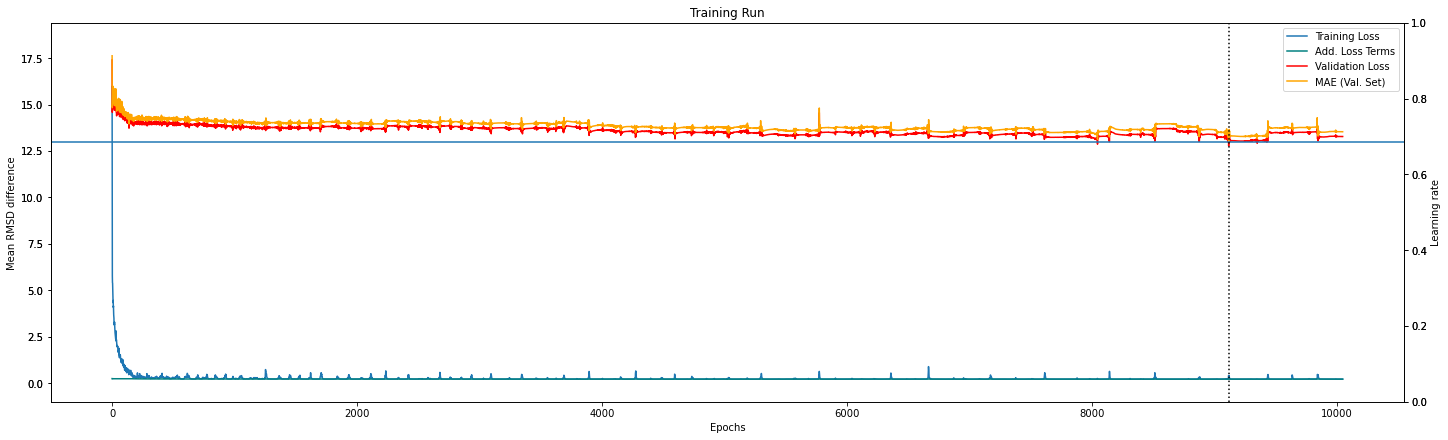

In [13]:
#plot the training run
select = 9118
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
Minimum Loss: Label = 21.3430, Prediction = 21.3372, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 28.3481, Loss = 27.8481
Mean Test loss: 	 9.9167
Std. Dev. of Test loss:  6.8286
Min loss: 		 0.0000
First Quantile: 	 4.3523
Median: 		 9.0920
Third Quantile: 	 14.2484
Max Loss: 		 27.8481
LinregressResult(slope=0.631422284729834, intercept=4.792872522531338, rvalue=0.28789639379411647, pvalue=1.0966390959793728e-06, stderr=0.12665705615015957, intercept_stderr=2.518861402005699)


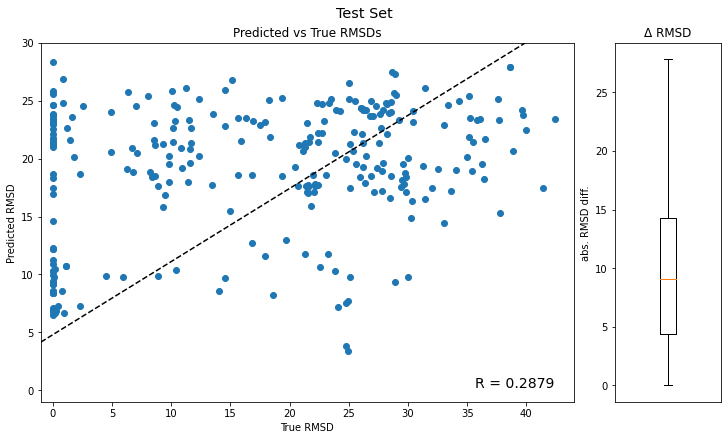

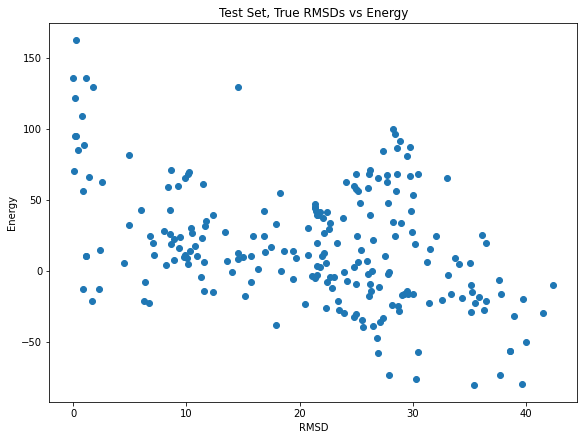

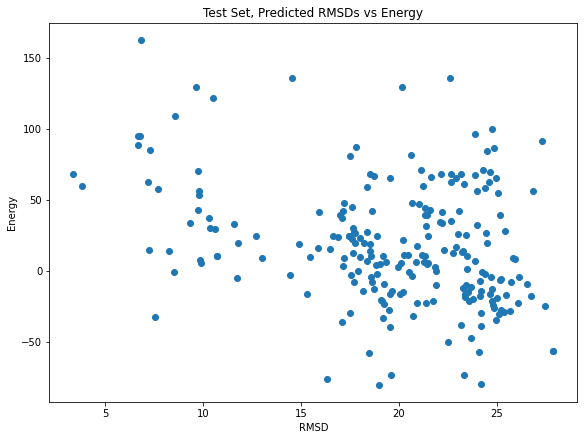

Prediction below 0: test_graph.y.item() = 20.371999740600586, test_pred.item() = -0.028194919228553772
5S and tRNA Test Set
Minimum Loss: Label = 25.8830, Prediction = 25.8747, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.8842, Loss = 26.3842
Mean Test loss: 	 4.0193
Std. Dev. of Test loss:  4.6306
Min loss: 		 0.0000
First Quantile: 	 0.9835
Median: 		 2.5265
Third Quantile: 	 5.2737
Max Loss: 		 26.3842
LinregressResult(slope=0.8751632035710983, intercept=0.6520015988967032, rvalue=0.7169506175390375, pvalue=1.4033883234743914e-171, stderr=0.025881948411487245, intercept_stderr=0.48886584336197814)


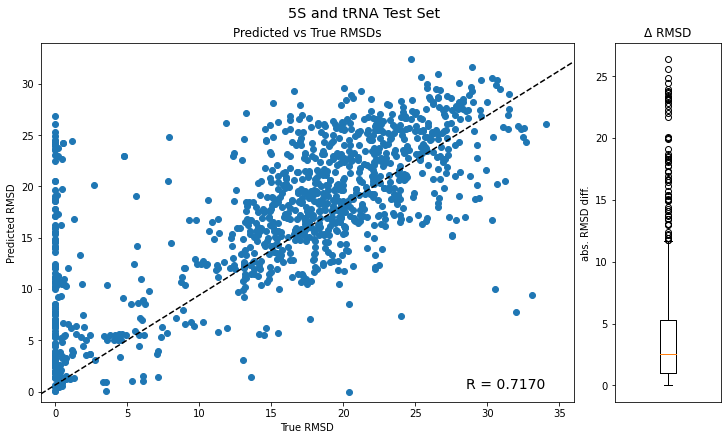

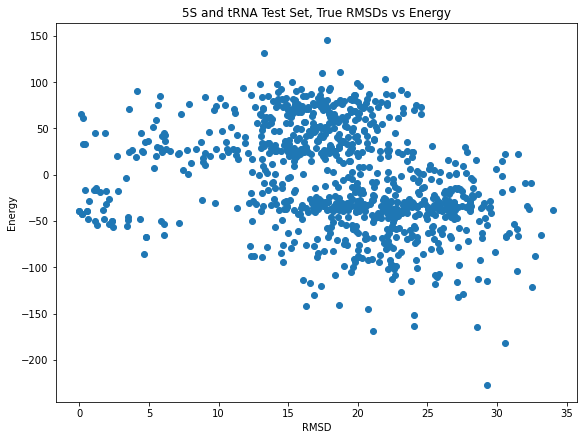

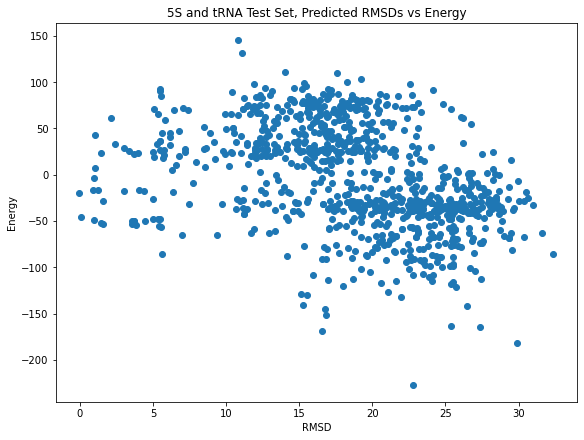

Prediction below 0: test_graph.y.item() = 0.2619999945163727, test_pred.item() = -0.5298173427581787
Prediction below 0: test_graph.y.item() = 0.2619999945163727, test_pred.item() = -0.5298173427581787
Prediction below 0: test_graph.y.item() = 0.18000000715255737, test_pred.item() = -0.5407091975212097
Prediction below 0: test_graph.y.item() = 0.15700000524520874, test_pred.item() = -0.731036901473999
Prediction below 0: test_graph.y.item() = 0.23399999737739563, test_pred.item() = -0.46112239360809326
Prediction below 0: test_graph.y.item() = 0.16200000047683716, test_pred.item() = -0.46509069204330444
Training Set
Minimum Loss: Label = 27.3160, Prediction = 27.3157, Loss = 0.0000
Maximum Loss: Label = 22.9270, Prediction = 18.4590, Loss = 3.9680
Mean Test loss: 	 0.1256
Std. Dev. of Test loss:  0.3090
Min loss: 		 0.0000
First Quantile: 	 0.0074
Median: 		 0.0336
Third Quantile: 	 0.1146
Max Loss: 		 3.9680
LinregressResult(slope=1.0061368487248001, intercept=0.020265100242081502, rv

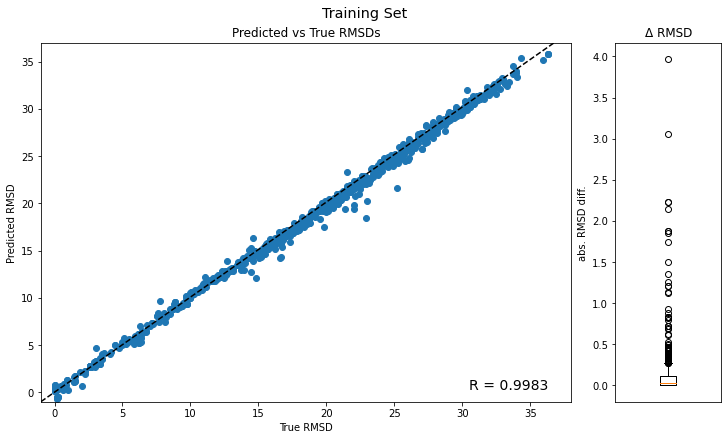

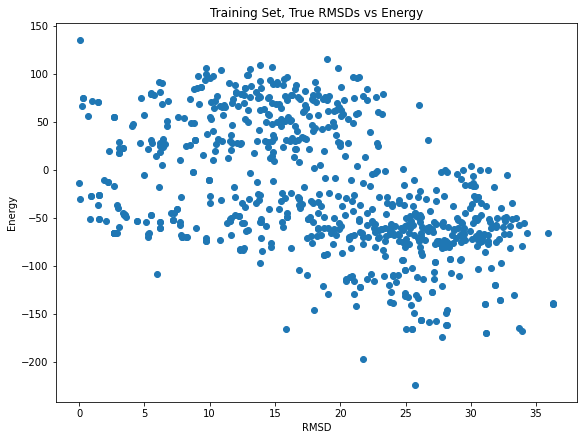

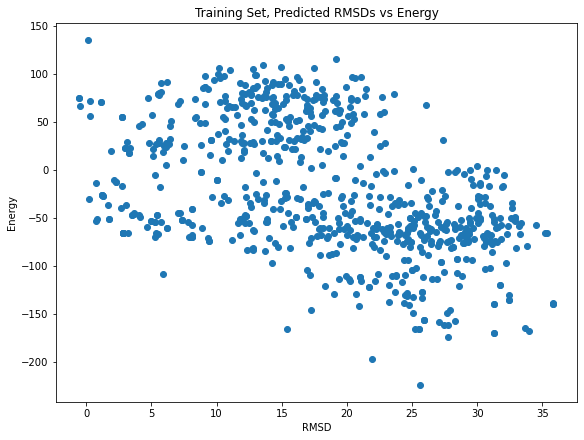

Validation Set
Minimum Loss: Label = 24.8880, Prediction = 24.8860, Loss = 0.0000
Maximum Loss: Label = 61.9850, Prediction = 19.8704, Loss = 41.6146
Mean Test loss: 	 12.5529
Std. Dev. of Test loss:  9.2151
Min loss: 		 0.0000
First Quantile: 	 4.2562
Median: 		 12.1039
Third Quantile: 	 18.6546
Max Loss: 		 41.6146
LinregressResult(slope=0.5989327563365491, intercept=10.443143055886036, rvalue=0.19783787384179402, pvalue=7.378950360529937e-05, stderr=0.14950324380509067, intercept_stderr=3.2923439385690005)


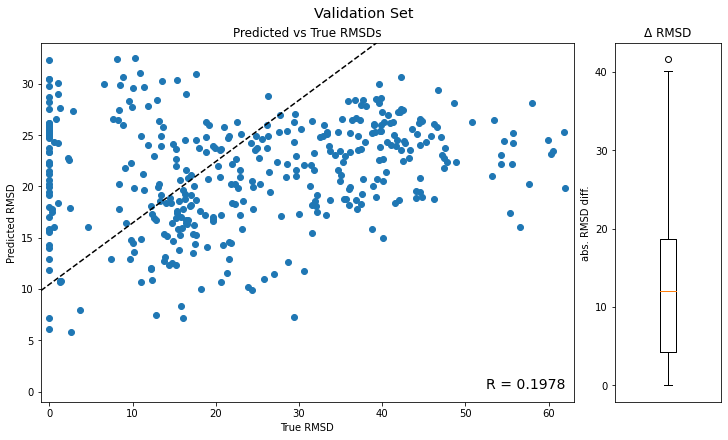

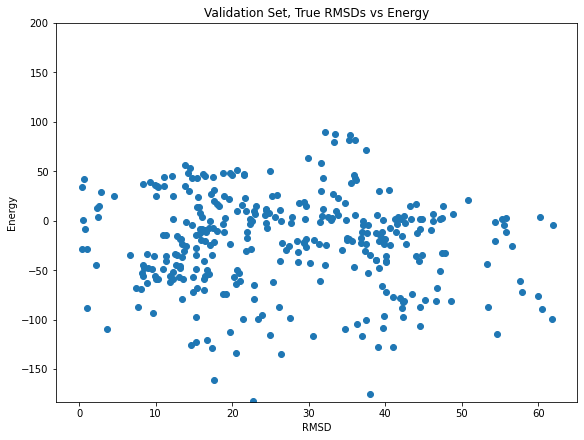

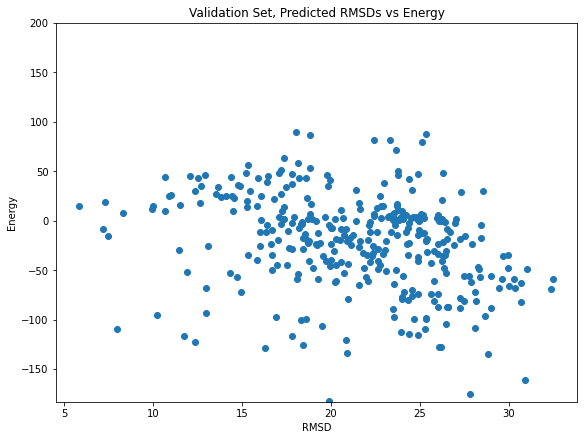

LinregressResult(slope=0.7759181180048568, intercept=5.681891564198692, rvalue=0.46502391628875633, pvalue=7.298296149694336e-81, stderr=0.03828095781593119, intercept_stderr=0.7819665500322479)


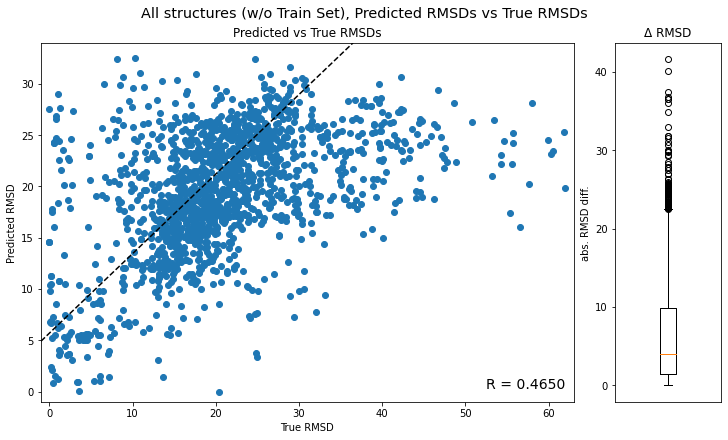

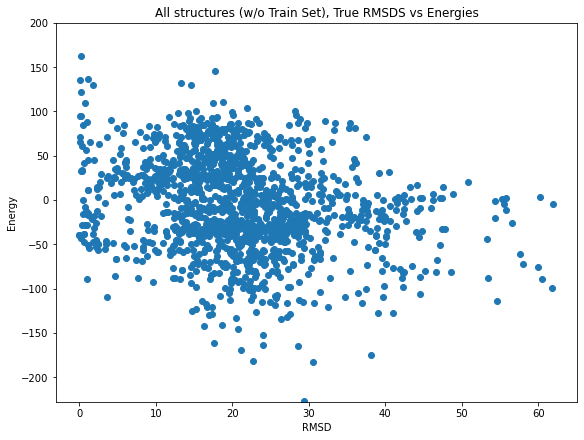

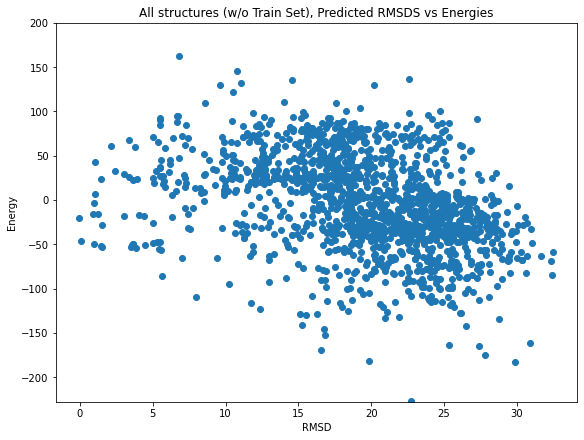

In [14]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9447600201618522, intercept=0.8898360324456895, rvalue=0.8966396175696395, pvalue=2.6636782523817723e-99, stderr=0.02813239447923864, intercept_stderr=0.5742500730230169)


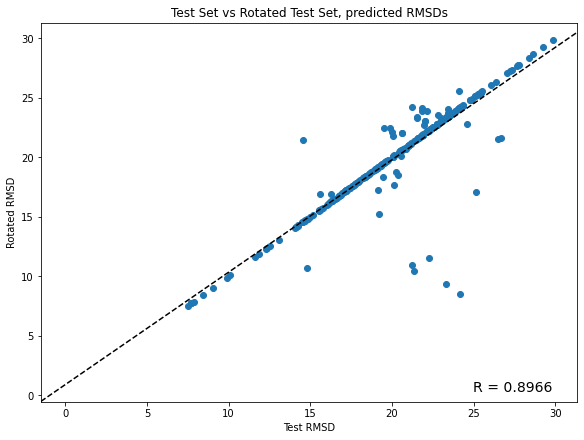

LinregressResult(slope=0.9424999079755717, intercept=0.39035894174070584, rvalue=0.9615166537699863, pvalue=2.5421899503978867e-156, stderr=0.01624017006163873, intercept_stderr=0.2057412381254121)


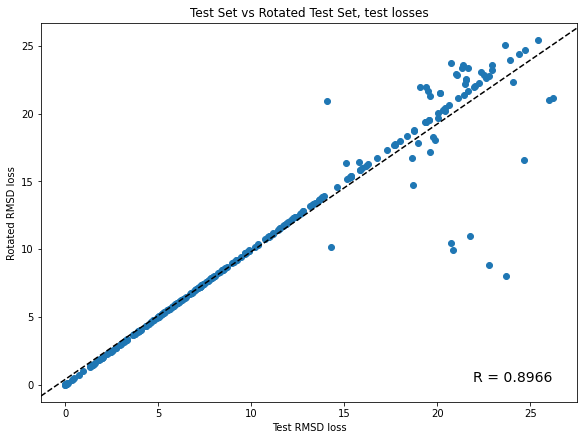

LinregressResult(slope=0.958856322839109, intercept=0.8392193239331043, rvalue=0.9732639830932204, pvalue=0.0, stderr=0.006882575520543485, intercept_stderr=0.13456805910990327)


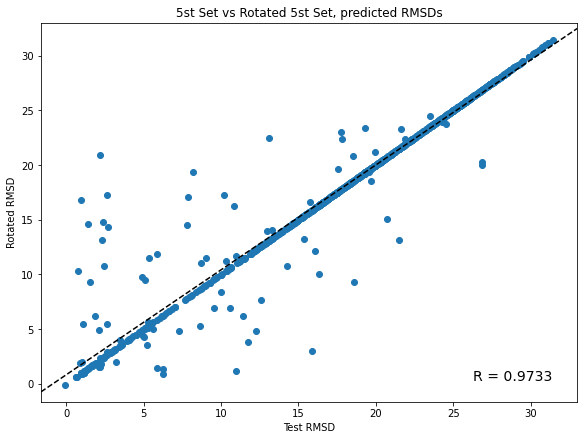

LinregressResult(slope=0.9517411194173927, intercept=0.28032267855981186, rvalue=0.9293467185831548, pvalue=0.0, stderr=0.011500044614865918, intercept_stderr=0.06800607679429661)


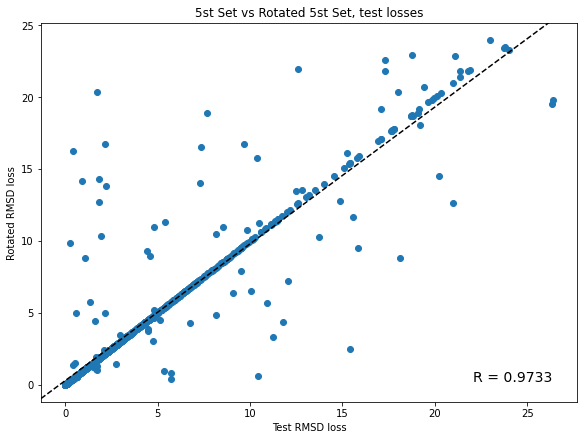

In [9]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")